#LANGUAGE TRANSLATION WITH NN.TRANSFORMER AND TORCHTEXT
### LAB05 NLP2 EPITA SCIA 2022
### Alexis JULIEN, Corention PION, Matthieu SCHLIENGER, Romain CAZIN

This tutorial shows:

How to train a translation model from scratch using Transformer.

Use tochtext library to access Multi30k dataset to train a German to English translation model.

In [ ]:
!pip install spacy sacrebleu torchdata -U
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [ ]:
!pip install -U torchtext

In [33]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List

#Data Sourcing and Processing

torchtext library has utilities for creating datasets that can be easily iterated through for the purposes of creating a language translation model. In this example, we show how to use torchtext’s inbuilt datasets, tokenize a raw text sentence, build vocabulary, and numericalize tokens into tensor. We will use Multi30k dataset from torchtext library that yields a pair of source-target raw sentences.

In [34]:
# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

In [35]:
# Create source and target language tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [36]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [37]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

#Seq2Seq Network using Transformer

Transformer is a Seq2Seq model introduced in “Attention is all you need” paper for solving machine translation tasks. Below, we will create a Seq2Seq network that uses Transformer. The network consists of three parts. 

First part is the embedding layer. This layer converts tensor of input indices into corresponding tensor of input embeddings. These embedding are further augmented with positional encodings to provide position information of input tokens to the model. 

The second part is the actual Transformer model. 

Finally, the output of Transformer model is passed through linear layer that give un-normalized probabilities for each token in the target language.

In [38]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor) -> float:
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


In [40]:
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor) -> nn.Embedding:
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


In [41]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)


During training, we need a subsequent word mask that will prevent model to look into the future words when making predictions. We will also need masks to hide source and target padding tokens. Below, let’s define a function that will take care of both.

In [42]:
def generate_square_subsequent_mask(sz: int):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src ,tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Let’s now define the parameters of our model and instantiate the same. Below, we also define our loss function which is the cross-entropy loss and the optmizer used for training.

In [43]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

#Collation
As seen in the Data Sourcing and Processing section, our data iterator yields a pair of raw strings. We need to convert these string pairs into the batched tensors that can be processed by our Seq2Seq network defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that can be fed directly into our model.


In [44]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Let’s define training and evaluation loop that will be called for each epoch.

In [45]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer) -> float:
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))


Now we have all the ingredients to train our model.

In [46]:
from timeit import default_timer as timer
NUM_EPOCHS = 20

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.344, Val loss: 4.114, Epoch time = 43.745s
Epoch: 2, Train loss: 3.761, Val loss: 3.320, Epoch time = 41.887s
Epoch: 3, Train loss: 3.162, Val loss: 2.895, Epoch time = 41.559s
Epoch: 4, Train loss: 2.768, Val loss: 2.639, Epoch time = 44.062s
Epoch: 5, Train loss: 2.481, Val loss: 2.441, Epoch time = 47.242s
Epoch: 6, Train loss: 2.250, Val loss: 2.317, Epoch time = 47.684s
Epoch: 7, Train loss: 2.060, Val loss: 2.202, Epoch time = 43.480s
Epoch: 8, Train loss: 1.897, Val loss: 2.113, Epoch time = 46.151s
Epoch: 9, Train loss: 1.755, Val loss: 2.062, Epoch time = 46.858s
Epoch: 10, Train loss: 1.631, Val loss: 2.004, Epoch time = 46.271s
Epoch: 11, Train loss: 1.524, Val loss: 1.973, Epoch time = 45.537s
Epoch: 12, Train loss: 1.419, Val loss: 1.941, Epoch time = 46.557s
Epoch: 13, Train loss: 1.333, Val loss: 1.968, Epoch time = 44.356s
Epoch: 14, Train loss: 1.252, Val loss: 1.943, Epoch time = 46.114s
Epoch: 15, Train loss: 1.173, Val loss: 1.932, Epoch time

In [69]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
        Return a translated sentence in form of a tensor using the greedy decoding approach.

        Parameters
        ----------
        model: torch model trained
        src: Tensor containing the sentence to be translated
        src_mask: Tensor
        max_len: int number of words we want in our translation
        start_symbol: int the first symbol in our sentence

        Returns
        -------
        outputs : Tensor filled with words indexes
    """
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)  #Tensor de la taille de la phrase , la taille grandit au fur et a mesure
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

In [58]:
import random
def topK_sampling_decode(model, src, src_mask, max_len, start_symbol, k):
    """
        Return a translated sentence in form of a tensor using the decoding topKSampling approach.

        Parameters
        ----------
        model: torch model trained
        src: Tensor containing the sentence to be translated
        src_mask: Tensor
        max_len: int number of words we want in our translation
        start_symbol: int the first symbol in our sentence
        k: int number of words we keep in the topk sampling

        Returns
        -------
        outputs : Tensor filled with words indexes
    """
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)  #Tensor de la taille de la phrase , la taille grandit au fur et a mesure
        prob = model.generator(out[:, -1])
        
        
        values_potential_next_words , indices_potential_next_words = torch.topk(prob, k)
        
        soft_max = torch.nn.functional.softmax(values_potential_next_words, dim=0)
        next_word = random.choices(indices_potential_next_words[0].tolist(), soft_max[0].tolist())[0]
      
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

In [59]:
def topK_sampling_temperature_decode(model, src, src_mask, max_len, start_symbol, k, temperature):
    """
        Return a translated sentence in form of a tensor using the decoding topKSampling with Temperature appraoch.

        Parameters
        ----------
        model: torch model trained
        src: Tensor containing the sentence to be translated
        src_mask: Tensor
        max_len: int number of words we want in our translation
        start_symbol: int the first symbol in our sentence
        k: int number of words we keep in the top ksampling
        temperature: float used to shade our probability space

        Returns
        -------
        outputs : Tensor filled with words indexes
    """
    assert 0 < temperature <= 1
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)  #Tensor de la taille de la phrase , la taille grandit au fur et a mesure
        prob = model.generator(out[:, -1])
        
        
        values_potential_next_words , indices_potential_next_words = torch.topk(prob, k)
        soft_max = torch.nn.functional.softmax(values_potential_next_words / temperature)
        next_word = random.choices(indices_potential_next_words[0].tolist(), soft_max[0].tolist())[0]
      
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys
    

TO DO for beamsearch

same arguments as greedy_decode BUT we add :
beam_depth_search : int  -> represents for how long we want to search the most optimals sequences of words
k : int -> represents for each steps how many best probabilites we want to keep.


pseudo-code :

-for every steps get the k most likely next words.

-for each of thoose words we look again for the k most likely next words

-we repeat this until we reach the beam_depth_search.

-we mesure the probability of each combinations of words with : |log(p1)xlog(p2)x...xlog(p_beam_search_depth)|

-we select the highest one

-and we use them as next words

In [125]:
#actual function to translate input sentence into target language with the GREEDY DECODE approach
def translate_greedy_decode(model: torch.nn.Module, src_sentence: str):
    """
        Returns a translated sentence using the greedy decoding approach
        Parameters
        ----------
        model: torch model trained
        src_sentence: Tensor containing the sentence to be translated
        
        Returns
        -------
        outputs : str the src_sentence translated by with the model and decoding with topKSampling with temperature 
    """
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [126]:
#actual function to translate input sentence into target language with the TOPK SAMPLING approach
def translate_topk_sampling_decode(model: torch.nn.Module, src_sentence: str, k: int):
    """
        Returns a translated sentence using the topk_sampling decoding approach
        Parameters
        ----------
        model: torch model trained
        src_sentence: Tensor containing the sentence to be translated
        k: int number of words we keep for the topKSampling
        


        Returns
        -------
        outputs : str the src_sentence translated by with the model and decoding with topKSampling with temperature 
    """
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = topK_sampling_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX, k =3).flatten()
    
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [127]:
#actual function to translate input sentence into target language with the TOPK SAMPLING WITH TEMPERATURE approach
def translate_topk_sampling_temperature_decode(model: torch.nn.Module, src_sentence: str, k :int, temperature : float):
    """
        Returns a translated sentence using the topk_sampling with temperature decoding approach
        Parameters
        ----------
        model: torch model trained
        src_sentence: Tensor containing the sentence to be translated
        k: int number of words we keep for the topKSampling
        temperature: float used to shade our probability space


        Returns
        -------
        outputs : str the src_sentence translated by with the model and decoding with topKSampling with temperature 
    """
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = topK_sampling_temperature_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX, k = 3, temperature = 0.8).flatten()
    
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [84]:
print(translate_greedy_decode(transformer, "Eine Gruppe von Menschen steht vor einem Iglu .")) #Un groupe de personne est debout devant un igloo

 A group of people stand in front of an olive office . 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


**We can see that the translation is quite good, but there is a problem for the word Igloo. It might be to specific to be correrctly understood.**

In [102]:
print(translate_topk_sampling_decode(transformer,"der kleine Tiger schwimmt.",3)) #Le petit tigre est en train de nager

 Two little tiger swims 


In [108]:
print(translate_topk_sampling_decode(transformer,"An diesem Wochenende gehen wir mit ein paar Freunden ins Kino, um einen Horrorfilm zu sehen.", 15)) 
#This weekend we are going to the movies with some friends to see a horror movie.

 We are very athletes are how how to see a great routine at what is seen in what 's studio 


**Here, with the topk-sampling-approach, the translation seems good aswell the only problem is the begining of the sentence.**

The value of k interfers in the results, if k is to big the translations are becoming completly wrong.

In [93]:
print(translate_topk_sampling_temperature_decode(transformer,"das Haus ist rot", k=3 , temperature = 0.8)) #The house is red

 The house is in red . 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [104]:
print(translate_topk_sampling_temperature_decode(transformer,"Hallo, ich bin ein Bäcker. Ich liebe es, mit meinen Freunden zu kochen", k=3 , temperature = 0.1))
# Hello, I'am a baker. I love to cook with my friends

 Beautiful I I I am a Japanese I ' I ' friends , and female friends cook . 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


**With the topk-sampling approach with tempertaure the translations is almost perfect.**

The results are complelty off if we take a temperatue to low

## BLUESCORE

Compute the BLEU score of the model

Explain what all the output values mean (when using the corpus_score function).

The output values of the corpus_score function looks like : 

"X A/B/C/D (BP = Y ratio = Z hyp_len = M ref_len = N)"

X is a float which refers to the final BLEU score of the model, it shows how well the machine's translations match human translations

A/B/C/D are floats that represents the precision value for 1-4 ngram order

Y is a float which represents the brevity penalty : it penalizes generated 
translations that are too short

Z is a float that indicates the ratio between hypothesis length and reference length

M is an int that refers to the total number of charcaters for hypothesis text

N is a int that refers to the total number of charcters for reference text

**We can see with the table belows how the BLUE score (X) is used to determine the quality of the translation**

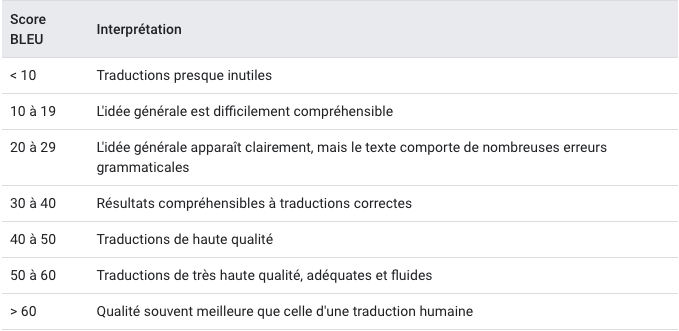

In [119]:
from sacrebleu.metrics import BLEU

#We create batches of references texts and their associated translations
input = ["der Horrorfilm war gut", "An diesem Wochenende gehen wir mit ein paar Freunden ins Kino, um einen Horrorfilm zu sehen. Ich habe ein Schokoladeneis gegessen.", "Hallo, ich bin ein Bäcker. Ich liebe es, mit meinen Freunden zu kochen", "das Haus ist rot", "der kleine Tiger schwimmt.", "Eine Gruppe von Menschen steht vor einem Iglu."]
refs = ["the horror film was good", "This weekend we are going to the movies with some friends to see a horror movie. I ate a chocolate ice cream", "Hello, I'am a baker. I love to cook with my friends", "The house is red", "The little tiger is swimming", "A group of people are standing in front of an igloo"]


In [132]:
##BLEU SCORE for the greedy decode
res = []
for elmt in input:
  res.append(translate_greedy_decode(transformer, elmt))

greedy_refs = [refs]

bleu = BLEU()

bleu.corpus_score(res, greedy_refs)

BLEU = 15.60 41.2/18.9/11.8/6.5 (BP = 1.000 ratio = 1.311 hyp_len = 80 ref_len = 61)

**For the greedy decode appriach we can see that we get a BLEU score of 15.60. The translations get the main ideas of the sentences but they are significantly different than the referneces. We can note that the length of the translated sentences are generally much longer than the reference sentence. It reveals that the model is creating some infromations from nowhere (which is bad for a transaltion). The 1-gram score is pretty decent for this amount of training.**

In [138]:
##BLEU SCORE for the topk_samling decode
res3 = []
res5 = []
res10 = []
for elmt in input:
  res3.append(translate_topk_sampling_decode(transformer, elmt,3))
  res5.append(translate_topk_sampling_decode(transformer, elmt,5))
  res10.append(translate_topk_sampling_decode(transformer, elmt,10))

topk_sampling_refs = [refs]

bleu = BLEU()

print(f"The BLEU score for k = 3 \n",bleu.corpus_score(res3, topk_sampling_refs))
print("")
print(f"The BLEU score for k = 5 \n",bleu.corpus_score(res5, topk_sampling_refs))
print("")
print(f"The BLEU score for k = 10 \n",bleu.corpus_score(res10, topk_sampling_refs))

The BLEU score for k = 3 
 BLEU = 0.89 14.5/0.6/0.4/0.2 (BP = 1.000 ratio = 1.361 hyp_len = 83 ref_len = 61)

The BLEU score for k = 5 
 BLEU = 7.20 24.7/8.9/4.1/3.0 (BP = 1.000 ratio = 1.393 hyp_len = 85 ref_len = 61)

The BLEU score for k = 10 
 BLEU = 3.01 23.0/3.7/1.3/0.7 (BP = 1.000 ratio = 1.426 hyp_len = 87 ref_len = 61)


**For the topksampling approach we can see that the BLEU SCOREs are really low (under 10)  which are really bad translations. The 1-gram score isn't good, and the 2-gram falls immietiadly after. To be honest we don't really get why it is this bad when some shorts translations are working (like above for the tiger's example). We can see that we get 'best results' == 'the least worst' score when the k is set at 5**

In [154]:
##BLEU SCORE for the topk_sampling with temperature decode
res_2 = []
res_5 = []
res_8 = []
for elmt in input:
  res_2.append(translate_topk_sampling_temperature_decode(transformer, elmt,3,0.2))
  res_5.append(translate_topk_sampling_temperature_decode(transformer, elmt,3,0.5))
  res_8.append(translate_topk_sampling_temperature_decode(transformer, elmt,3,0.8))

topk_sampling__temperature_refs = [refs]

bleu = BLEU()

print(f"The BLEU score for k = 3 and the temperature = 0.2 \n",bleu.corpus_score(res_2, topk_sampling_refs))
print("")
print(f"The BLEU score for k = 3 and the temperature = 0.5 \n",bleu.corpus_score(res_5, topk_sampling_refs))
print("")
print(f"The BLEU score for k = 3 and the temperature = 0.8 \n",bleu.corpus_score(res_8, topk_sampling_refs))
print("")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The BLEU score for k = 3 and the temperature = 0.2 
 BLEU = 13.75 31.7/15.8/11.4/6.2 (BP = 1.000 ratio = 1.344 hyp_len = 82 ref_len = 61)

The BLEU score for k = 3 and the temperature = 0.5 
 BLEU = 13.83 34.2/14.9/9.8/7.3 (BP = 1.000 ratio = 1.197 hyp_len = 73 ref_len = 61)

The BLEU score for k = 3 and the temperature = 0.8 
 BLEU = 19.81 43.2/20.6/16.1/10.7 (BP = 1.000 ratio = 1.213 hyp_len = 74 ref_len = 61)



**For the topksampling with temperature we are getting a BLEU SCORE just around 20 with a temperature of 0.80 . There is an improvement from the greedy appraoch, which is comforting.**

To sum up this notebook, our results are getting better with the topk sampling appraoch associated with temperature. The score of the normal topk sampling is really strange to us. We believe that we can see an improvement in our results with a longer training time for the model.